<a href="https://colab.research.google.com/github/Camicb/Copper-Forecasting/blob/main/Part_1_Price_Copper_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
In Chile there are 26 mining deposits that produce 5.7 million tons of copper per year, which represents 28% of world production [[1]](https://www.elmostrador.cl/noticias/opinion/2021/03/28/importancia-del-cobre-cu-en-la-descarbonizacion-de-la-economia-mundial-y-su-impacto-en-chile/). This relative abundance of copper has made it the main export of Chile and therefore its contribution is vital to the Chilean economy. Anticipating the price of copper allows the estimation of the profitability of related projects and their viability over time.

Forecasting is the prediction on data with a time dimension. In this project, I will forecast the price of copper, with data manually extracted from the Chilean Copper Commission, [COCHILCO](https://boletin.cochilco.cl/estadisticas/grafico.asp?tipo_metal=1) from years 1999 to 2021 (today).

The data was extracted, joined, and cleaned using Microsoft Excel, and then uploaded to [Google Drive](https://drive.google.com/drive/folders/1wOgmeZFQf45oADTYtOP6iC8aNTEyDvuX?usp=sharing). For the analysis, I will use traditional ARIMA models and the library Facebook Prophet. I will not consider other variables like the dollar value or international situations that have been associated with the increased or decreased price. The impacts of these variables will be study in the second part of this project, [here]

In [1]:
# Installing required libraries

!pip install pystan -q
!pip install fbprophet -q
!pip install statsmodels -q
!pip install pmdarima -q
!pip install scipy -q

     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 2.1MB 46.0MB/s 
     |████████████████████████████████| 9.5MB 35.8MB/s 


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [3]:
# For reproducibility
np.random.seed(2021)

# Price Copper Forecasting

The copper price is determined worldwide by the [London Metal Exchange](https://www.lme.com/en-GB/Metals/Non-ferrous/Copper#tabIndex=0). 
The data provided by COCHILCO have 2 variables:


*   **Fecha** : Datetime
*   **Precio Nominal Cobre Diario (¢/lb)**: the price, in cents per pound of copper



In [4]:
# Loading the data
price = pd.read_excel('/content/drive/MyDrive/DATASETS/Copper/precio_cobre.xlsx')

In [5]:
# Inspecting the data
price.tail()
print(' ')
price.info()
print(' ')
price.describe()

,Fecha,Precio Nominal Cobre Diario (¢/lb)
5613,2021-03-22,412.66
5614,2021-03-23,408.98
5615,2021-03-24,408.96
5616,2021-03-25,398.30
5617,2021-03-26,405.01


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5618 entries, 0 to 5617
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Fecha                               5618 non-null   datetime64[ns]
 1   Precio Nominal Cobre Diario (¢/lb)  5618 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 87.9 KB
 


,Precio Nominal Cobre Diario (¢/lb)
count,5618.000000
mean,237.792602
std,109.946089
min,59.830000
25%,131.142500
50%,265.620000
75%,323.910000
max,460.310000


In [6]:
# Redefining variables for simplification purposes
price.rename(columns={'Fecha': 'ds'}, inplace=True)
price.rename(columns={'Precio Nominal Cobre Diario (¢/lb)': 'y'}, inplace=True)

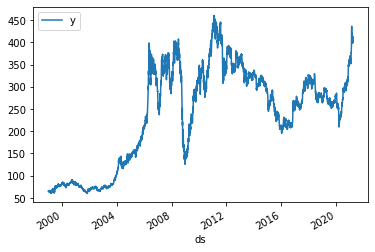

In [7]:
# Visualizing data
price.plot(x='ds',y='y')

In [8]:
# Spliting data into training and testing datasets
train_size_price = int(price.shape[0]*0.9)
train_price = price[0:train_size_price] # 90% data
test_price = price[train_size_price:]  # 10% data

## 1. ARIMA based models

ARIMA, or Autoregressive Integrated Moving Average, is a very popular statistical method for time series forecasting. 

An ARIMA model can be considered as a special type of regression model. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

*   **p** (past values used for forecasting the next value)
*   **q** (past forecast errors used to predict the future values)
*  **d** (order of differencing)

Parameter tuning for ARIMA consumes a lot of time. So for this project I will use auto ARIMA, which automatically selects the best combination of (p,q,d) that provides the least error. 

In [9]:
# Inspecting ARIMA models

train_price.index = train_price['ds']
test_price.index =test_price['ds']

model_price = auto_arima(train_price['y'], start_p=1, start_q=1,max_p=5, max_q=5, max_d=5, m=1, max_D=5, trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28804.216, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28813.806, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28802.723, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28803.065, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28812.270, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28804.026, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28796.480, Time=3.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28798.380, Time=6.56 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28798.401, Time=7.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28796.358, Time=4.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28803.929, Time=1.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=28807.683, Time=2.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=28805.623, Time=1.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28793.661, Time=11.73 sec
 ARIMA(3,1,3)(0,0,

In [10]:
# Model selection
model_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5056
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -14389.830
Date:                Mon, 29 Mar 2021   AIC                          28793.661
Time:                        19:49:19   BIC                          28839.358
Sample:                             0   HQIC                         28809.668
                               - 5056                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2989      0.205      1.457      0.145      -0.103       0.701
ar.L1         -1.6637      0.010   -161.624      0.000      -1.684      -1.644
ar.L2         -0.9762      0.010    -98.369      0.000      -0.996      -0.957
ma.L1          1.6112      0.013    120.261      0.000       1.585       1.637
ma.L2          0.8802      0.018     48.869      0.000       0.845       0.915
ma.L3         -0.0542      0.009     -6.056      0.000      -0.072      -0.037
sigma2        17.5551      0.207     84.654      0.000      17.149      17.962
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              3384.99
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               5.69   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Making predictions
price_predictions = pd.DataFrame(model_price.predict(n_periods=562))
price_predictions.index=test_price.index
price_predictions.columns = ['predictions']
price_predictions

,predictions
ds,
2019-01-09,267.891807
2019-01-10,267.918683
2019-01-11,268.063654
2019-01-14,268.095077
2019-01-15,268.200130
...,...
2021-03-22,313.600540
2021-03-23,313.682572
2021-03-24,313.764751


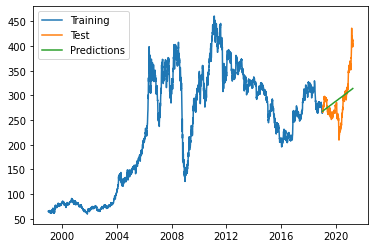

In [12]:
# Visualizing results
plt.plot(train_price['y'], label='Training')
plt.plot(test_price['y'], label='Test')
plt.plot(price_predictions['predictions'], label='Predictions')
plt.legend()

In [13]:
# Metrics
mean_squared_error(test_price['y'], price_predictions['predictions'])

1376.3743535186186

An auto ARIMA model uses past data to understand the pattern in the time series. Using these values, as its evident from the plot, the model captured an increasing trend in the prices, but did not focus on the seasonal part; therefore, the predictions are not close to the real values and the error is significant.

##2. Facebook Prophet

Facebook Prophet is open source software released by Facebook’s Core Data Science team. 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It requires two variables : a column with the datetimes named 'ds', and column with the values named 'y'.




In [14]:
# Creating model
m_price= Prophet(daily_seasonality=True)
m_price.fit(train_price)
future_price = m_price.make_future_dataframe(periods=808,freq='D') 
future_price.tail()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds
5855,2021-03-22
5856,2021-03-23
5857,2021-03-24
5858,2021-03-25
5859,2021-03-26


In [15]:
# Making predictions
forecast_price = m_price.predict(future_price)
forecast_price[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5855,2021-03-22,309.511193,173.920808,430.279231
5856,2021-03-23,310.023187,173.354350,431.963845
5857,2021-03-24,310.010817,173.429886,438.417877
5858,2021-03-25,310.599387,175.439195,434.125893
5859,2021-03-26,310.994682,175.411585,439.794352


The model provided the values:

**yhat**: the forecasted value (the predicted values for y)

**yhat_lower**: the lower bound of the forecast

**yhat_upper**: the upper bound of the forecast

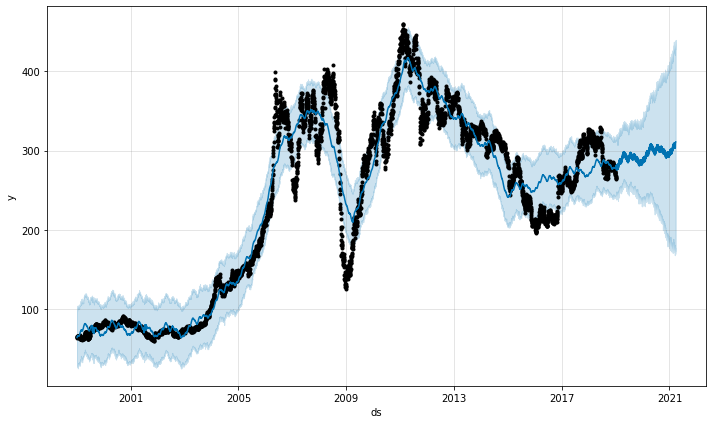

In [16]:
# Plot the forecast
fig1 = m_price.plot(forecast_price, uncertainty=True)


Prophet plots the observed values of time series (black dots), the forecasted values (blue lines) and the uncertainty intervals of the forecasts ( blue shaded region).

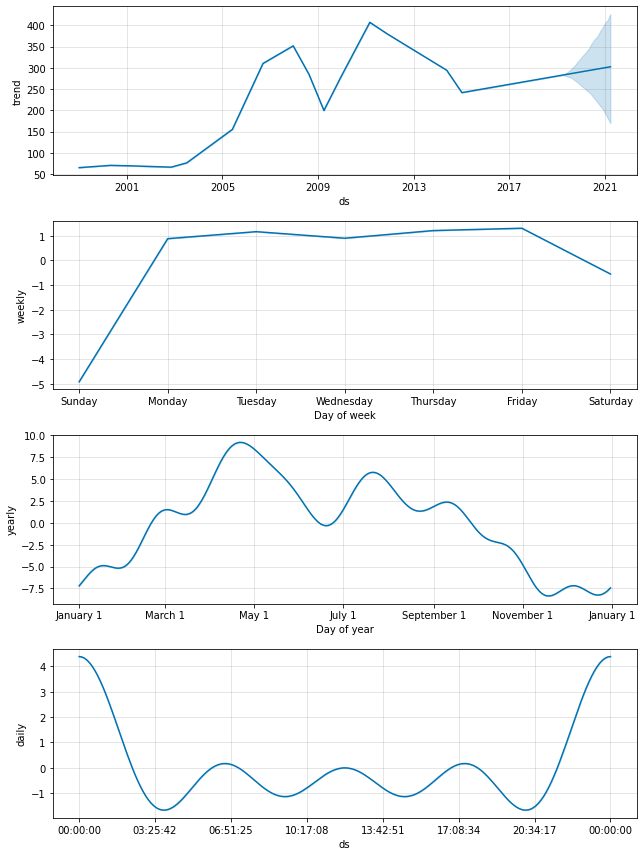

In [17]:
# Plot forecast components
fig2 = m_price.plot_components(forecast_price)

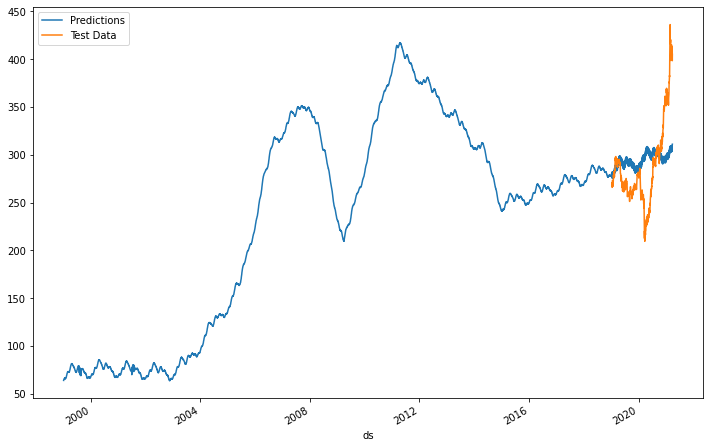

In [18]:
# Plot test data and predictions
ax_price=forecast_price.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8))
test_price.plot(x='ds',y='y',legend=True,label='Test Data',ax=ax_price)


In [19]:
# Metrics
y_test = test_price['y']
y_predict = forecast_price['yhat'][-562:]
mean_squared_error(y_test, y_predict)

1926.4280601715986

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time-series datasets but fails in this case, where the error is even worse compared with the ARIMA model.


### **Conclusion**
As it turns out, copper prices do not have a particular trend or seasonality. They highly depend on the national and international markets situation. Hence forecasting techniques like ARIMA, SARIMAX and Prophet would not show good results for these problems. 

# Bibliography

*  https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

*  https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

*  https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA

*  https://facebook.github.io/prophet/docs/quick_start.html#python-api

*  https://sailajakarra.medium.com/facebook-prophet-for-time-series-cf26be1be274

